# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27925691 entries, 0 to 27925690
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 852.2 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07,2.792569e+07
mean,2.994550e+00,8.774559e-01,3.462970e-01,9.547825e-01,6.769805e-01,8.453345e-02,5.450042e-02
std,7.375757e+00,3.660644e+00,5.648575e-01,2.670434e+00,7.561602e-01,1.120087e+00,2.350896e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,1.734900e+04,7.976000e+03,6.120000e+02,5.096000e+03,2.368000e+03,3.118000e+03,8.800000e+01


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          27925691
n_isbns          13201869
n_loc_recs        9314956
n_ol_editions    20525956
n_ol_works       17723553
n_gr_books        1509661
n_gr_works        1509137
dtype: int64

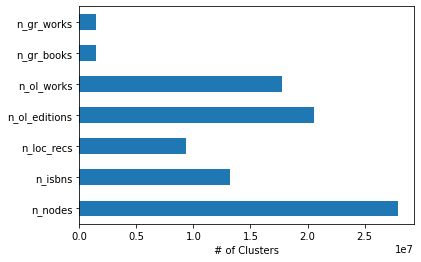

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,14723822
1,n_isbns,2,6256782
2,n_isbns,1,5807972
3,n_isbns,4,551072
4,n_isbns,3,268793


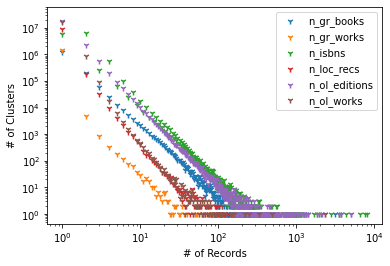

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 100004141 to 100418190
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        6694 non-null   uint32
 1   n_isbns        6694 non-null   uint32
 2   n_loc_recs     6694 non-null   uint32
 3   n_ol_editions  6694 non-null   uint32
 4   n_ol_works     6694 non-null   uint32
 5   n_gr_books     6694 non-null   uint32
 6   n_gr_works     6694 non-null   uint32
dtypes: uint32(7)
memory usage: 235.3 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0002397075868239035

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100004141,17349,7976,612,5066,489,3118,88
100066430,10906,3731,408,5096,329,1264,78
100307111,448,163,4,91,74,60,56
100162584,873,327,67,269,75,81,54
100092083,1113,424,61,231,145,200,52


## Large Cluster Debugging

We have some pretty big clusters:

In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100004141,17349,7976,612,5066,489,3118,88
105723403,11281,7520,0,3760,1,0,0
100066430,10906,3731,408,5096,329,1264,78
100379578,10132,6518,7,3572,35,0,0
100089994,7102,3540,162,1839,113,1421,27


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs
isbn_id,,,,,,
15102092,9780868400990,0,1,0,0,0
23264756,1625260903,0,0,1,0,0
10076874,9781410921079,0,1,0,0,0
7271695,0398007683,0,2,0,0,1
10502066,0781703409,0,1,0,0,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,3625780,117818401
1,1154412,103051383
2,3807428,102841488
3,183807,110728990
4,22530578,922530578


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs
24454224,8904736,0001004735,0,1,0,0,0
24452661,17818548,0001848259,0,1,0,0,0
24448911,11564794,0003708853,0,2,0,0,0
24451904,9646896,0004214072,0,2,0,0,0
24454355,12108303,0004214501,0,1,0,0,0
...,...,...,...,...,...,...,...
24454769,15774337,9997718135,0,1,0,0,0
24454704,21335562,9998392802,0,1,0,0,0
24448989,14240451,9998556643,0,1,0,0,0
24450205,14968293,9998651174,0,1,0,0,0


What are the things with the highest record count (besides ratings)?

In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,loc_recs,ol_recs,gr_recs,bx_recs,az_recs,btot
24449183,7214985,1559029838,0,12,1,180,0,13
24449184,7214986,9781559029834,0,11,0,0,0,11
24449067,871160,0394848284,3,6,0,2,4,9
24447586,8107936,1577595394,0,7,1,0,0,8
24447861,4828587,9780192727992,1,6,1,0,0,8
24450649,1395236,0716631970,4,4,0,0,0,8
24451967,4145077,9781402726019,3,4,1,0,0,8
24447584,8107938,9781577595397,0,6,1,0,0,7
24449663,5108168,9780674035751,1,6,0,0,0,7
24451971,4145078,1402726015,2,4,1,0,31,7


### Graph Analysis

Now let's start looking at this graph itself.

In [17]:
from igraph import Graph

In [18]:
g = Graph.Read_GML('book-links/debug-graph.gml')
g

In [19]:
btw = g.betweenness()
btw = np.array(btw)
btw

array([ 103268.02564102,       0.        ,   17345.        , ...,
         34693.        ,  183483.00362315, 1264490.5       ])

In [20]:
gdf = pd.DataFrame.from_records(v.attributes() for v in g.vs)
gdf['btw'] = btw
gdf.nlargest(15, 'btw')

,id,namespace,label,btw
7640,901395236.0,ISBN,0716631970,7.502116e+07
9433,106951868.0,OL-W,/works/OL15400121W,7.377814e+07
165,219017518.0,OL-E,,6.626119e+07
8472,112077510.0,OL-W,/works/OL15088605W,5.825185e+07
17139,107018071.0,OL-W,/works/OL13101191W,5.544139e+07
6406,214432315.0,OL-E,,5.381729e+07
7196,907214985.0,ISBN,1559029838,5.065767e+07
6436,103886697.0,OL-W,/works/OL69641W,5.022076e+07
272,907214986.0,ISBN,9781559029834,4.628061e+07
10407,223185437.0,OL-E,,4.257145e+07


In [21]:
g.diameter()

58

In [22]:
gdf['ecc'] = g.eccentricity()
gdf.nsmallest(15, 'ecc')

,id,namespace,label,btw,ecc
165,219017518.0,OL-E,,6.626119e+07,29.0
465,901395287.0,ISBN,0716631997,2.818977e+06,30.0
7640,901395236.0,ISBN,0716631970,7.502116e+07,30.0
9433,106951868.0,OL-W,/works/OL15400121W,7.377814e+07,30.0
168,206245856.0,OL-E,,3.469300e+04,31.0
322,205834015.0,OL-E,,3.361817e+05,31.0
329,216908191.0,OL-E,,0.000000e+00,31.0
387,224591444.0,OL-E,,3.469300e+04,31.0
393,205741815.0,OL-E,,3.469300e+04,31.0
405,205066333.0,OL-E,,0.000000e+00,31.0
